In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [6]:
df_fusionne = pd.read_csv("V2AIX/joined_data.csv")

In [7]:
# 🕒 1. Convertir le timestamp en datetime
df_fusionne["timestamp"] = pd.to_datetime(df_fusionne["recording_timestamp_nsec"], unit="ns")

# 🧮 2. Trier les messages par véhicule et par temps
df_fusionne = df_fusionne.sort_values(by=["message_header_station_id_value", "timestamp"])

# ⏱️ 3. Calculer le temps écoulé entre deux messages pour chaque véhicule
df_fusionne["delta"] = df_fusionne.groupby("message_header_station_id_value")["timestamp"].diff().dt.total_seconds()

# 📍 4. Identifier un nouveau trajet si l'écart entre deux messages > 5 minutes
inactivity_threshold = 300  # 300 secondes = 5 minutes
df_fusionne["new_trip"] = (df_fusionne["delta"] > inactivity_threshold) | (df_fusionne["delta"].isna())

# 🔁 5. Numéroter les trajets successifs pour chaque station_id
# Cela donne un trip_id relatif par station
df_fusionne["trip_local_id"] = df_fusionne.groupby("message_header_station_id_value")["new_trip"].cumsum()

# 🆔 6. Créer un identifiant global de trajet unique (station_id_trip_local_id)
# Cela garantit que chaque ligne appartient à un trajet unique
df_fusionne["trip_id"] = df_fusionne["message_header_station_id_value"].astype(str) + "_" + df_fusionne["trip_local_id"].astype(str)

In [8]:
df_fusionne["trip_local_id"].value_counts()

trip_local_id
1    256495
2      6327
3       645
Name: count, dtype: int64

In [9]:
# Convertir les coordonnées
df_fusionne["latitude"] = df_fusionne["message_cam_cam_parameters_basic_container_reference_position_latitude_value"] / 1e7
df_fusionne["longitude"] = df_fusionne["message_cam_cam_parameters_basic_container_reference_position_longitude_value"] / 1e7

In [10]:
# Filtrer les lignes valides
df_fusionne = df_fusionne[(df_fusionne["latitude"] != 0) & (df_fusionne["longitude"] != 0)]

In [11]:
# Étape 1 – Création des colonnes utiles (en prenant en compte les bons noms)
df_fusionne["speed"] = df_fusionne["message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_speed_speed_value_value"] / 100
df_fusionne["acceleration"] = df_fusionne["message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_longitudinal_acceleration_longitudinal_acceleration_value_value"] / 100
df_fusionne["yaw_rate"] = df_fusionne["message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_yaw_rate_yaw_rate_value_value"].abs() / 100
df_fusionne["curvature"] = df_fusionne["message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_curvature_curvature_value_value"]
df_fusionne["length"] = df_fusionne["message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_vehicle_length_vehicle_length_value_value"]
df_fusionne["width"] = df_fusionne["message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_vehicle_width_value"]


In [12]:
# Étape 3 – Agrégation par trajet (via trip_id)
df_trips = df_fusionne.groupby("trip_id").agg({
    "message_header_station_id_value": "first",  # on garde l'identifiant du véhicule
    "trip_local_id": "first",                    # numéro du trajet pour ce véhicule
    "speed": ["mean", "std"],
    "acceleration": ["mean", "std"],
    "yaw_rate": "mean",
    "curvature": "mean",
    "length": "first",  # constant normalement pour un véhicule
    "width": "first",
    "latitude": ["first", "last"],
    "longitude": ["first", "last"],
    "timestamp": [  # ici on récupère directement les datetimes complets
        "min",  # début de trajet
        "max",  # fin de trajet
        lambda x: (x.max() - x.min()).total_seconds()
    ]
}).reset_index()


In [13]:
# Aplatir les noms de colonnes
df_trips.columns = ['trip_id', 'station_id', 'trip_local_id',
                    'speed_mean', 'speed_std',
                    'acc_mean', 'acc_std',
                    'yaw_rate_mean', 'curvature_mean',
                    'length', 'width','latitude_start', 'latitude_end',
                    'longitude_start', 'longitude_end',
                    'start_time', 'end_time', 'trip_duration_seconds']

In [14]:
df_trips = df_trips.dropna()

In [15]:
# Dictionnaire des dimensions → modèle
car_dimensions = {
    (51, 19): "VW T7 Multivan (long)",
    (49, 19): "VW T7 Multivan (standard)",
    (49, 18): "VW ID.7",
    (47, 19): "VW ID. Buzz",
    (46, 18): "VW Golf 8 Variant",
    (45, 18): "VW ID.4 / VW ID.5",
    (42, 18): "VW Golf 8 / ID.3 / Cupra Born",
}

# Fonction de mappage (renvoie None si modèle inconnu)
def get_model(length, width):
    return car_dimensions.get((round(length, 1), round(width, 1)))

# Appliquer la fonction
df_trips["model"] = df_trips.apply(lambda row: get_model(row["length"], row["width"]), axis=1)

# Supprimer les lignes sans modèle reconnu
df_trips = df_trips.dropna(subset=["model"])

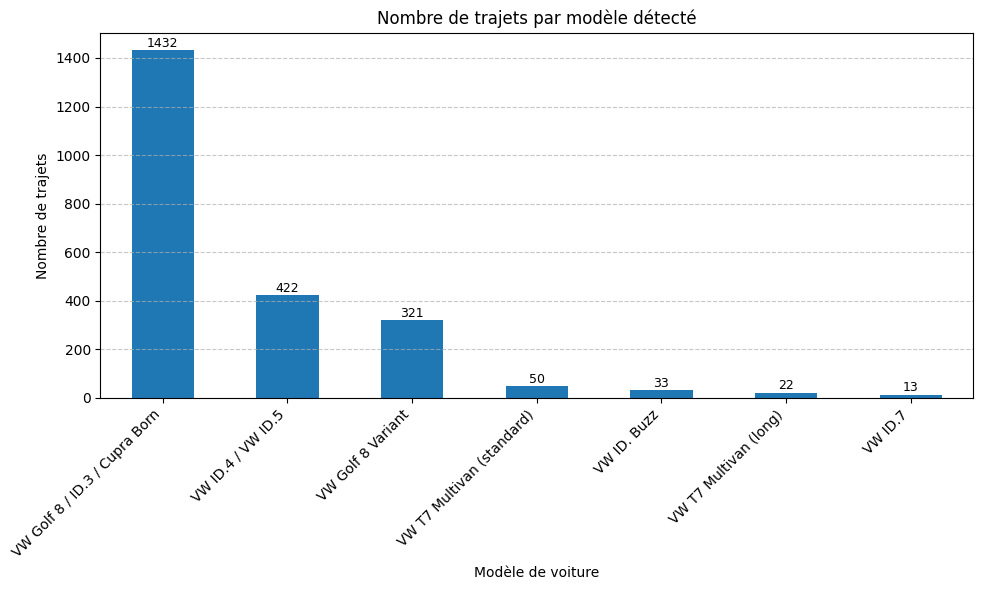

In [16]:
model_counts = df_trips["model"].value_counts()

# Création d'une nouvelle figure pour le graphique, avec une taille personnalisée
plt.figure(figsize=(10, 6))

# Création du barplot avec les valeurs comptées
ax = model_counts.plot(kind='bar')  # On stocke l'objet du graphique dans 'ax' pour ajouter des éléments ensuite

# Ajout d'un titre au graphique
plt.title('Nombre de trajets par modèle détecté')

# Étiquettes des axes
plt.xlabel('Modèle de voiture')
plt.ylabel('Nombre de trajets')

# Rotation des étiquettes sur l'axe x pour qu'elles soient lisibles
plt.xticks(rotation=45, ha='right')  # 'ha' = horizontal alignment

# Ajout de la grille (lignes horizontales pour faciliter la lecture)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Pour chaque barre, on affiche la valeur correspondante au-dessus
for i, value in enumerate(model_counts):
    ax.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=9)

# Ajustement automatique des marges pour ne rien couper à l’affichage
plt.tight_layout()

# Affichage du graphique
plt.show()

In [17]:
model_to_id = {
    "VW Golf 8 / ID.3 / Cupra Born": 1,
    "VW ID.4 / VW ID.5": 2,
    "VW Golf 8 Variant": 3,
    "VW ID. Buzz": 4,
    "VW ID.7": 5,
    "VW T7 Multivan (standard)": 6,
    "VW T7 Multivan (long)": 7
}
df_trips['model_id'] = df_trips['model'].map(model_to_id)

Altitude dans la V2. Utile ?

In [18]:
def classify_hour(t):
    hour = t.hour
    if 6 <= hour < 10:
        return "Pendulaire - matin"
    elif 16 <= hour < 20:
        return "Pendulaire - soir"
    elif 10 <= hour < 16:
        return "En journée"
    else:
        return "Nuit"

df_trips["activity_period"] = df_trips["start_time"].apply(classify_hour)


In [19]:
df_trips["size"] = df_trips["length"] * df_trips["width"]

In [20]:
df_trips["trip_duration_minutes"] = df_trips["trip_duration_seconds"] / 60

In [21]:
df_trips["trip_duration_minutes"].describe()

count    2293.000000
mean        0.957609
std         1.314673
min         0.003268
25%         0.171593
50%         0.490122
75%         1.298122
max        23.971725
Name: trip_duration_minutes, dtype: float64

In [22]:
df_trips = df_trips.dropna(subset=["model_id"])
df_trips = df_trips[df_trips["model_id"].astype(str).str.strip() != ""]

In [23]:
df_trips.shape

(2293, 23)

In [24]:
# 📦 Exporter le DataFrame en fichier Excel
#df_trips.to_excel("df_trips.xlsx", index=False)

In [25]:
df_trips = df_trips[df_trips["trip_duration_seconds"] >= 60]

In [26]:
df_trips.shape

(768, 23)

In [27]:
# 1er test : station_id seul
dupes_station = df_trips[df_trips.duplicated(subset=["station_id"], keep=False)]

# Nombre de trip_id uniques par station_id
print("Station ID - pourcentage de trajets uniques :", 
      np.round(100 * df_trips["station_id"].nunique() / len(df_trips),2))

Station ID - pourcentage de trajets uniques : 98.44


In [28]:
# 1. Nombre de trajets par station
trajets_par_station = df_trips["station_id"].value_counts()

# 2. Combien de stations ont 1, 2, 3... trajets
distribution = Counter(trajets_par_station)

# 3. Calcul du numérateur (somme des chances pondérées)
numerateur = sum((1 / n) * (n * count) for n, count in distribution.items())

# 4. Total des trajets
total_trajets = len(df_trips)

# 5. Proba moyenne de tomber sur le bon trajet
P_global = numerateur / total_trajets

# 6. Affichage
print(f"🔐 Proba moyenne de réidentification avec station_id seul : {P_global:.4f} ({P_global*100:.2f}%)")


🔐 Proba moyenne de réidentification avec station_id seul : 0.9844 (98.44%)


In [29]:
for n, count in sorted(distribution.items()):
    trajets = n * count
    contrib = (1 / n) * trajets
    print(f"{count} véhicules ont {n} trajet(s) → {trajets} trajets → contribution {contrib:.1f}")

745 véhicules ont 1 trajet(s) → 745 trajets → contribution 745.0
10 véhicules ont 2 trajet(s) → 20 trajets → contribution 10.0
1 véhicules ont 3 trajet(s) → 3 trajets → contribution 1.0


In [30]:
def simulate_reidentification_probability(trajet_distribution):
    """
    Calcule la probabilité moyenne de réidentification d’un trajet
    connaissant seulement le station_id, en fonction d’une distribution
    :param trajet_distribution: dict {nombre_de_trajets: nombre_de_véhicules}
    """
    total_trajets = 0
    total_chances = 0
    
    for n_trajets, nb_vehicules in trajet_distribution.items():
        trajets = n_trajets * nb_vehicules
        contribution = trajets * (1 / n_trajets)
        total_trajets += trajets
        total_chances += contribution
        print(f"{nb_vehicules} véhicules ont {n_trajets} trajet(s) → {trajets} trajets → contribution {contribution:.2f}")
    
    proba = total_chances / total_trajets
    print(f"\n🔐 Proba moyenne de réidentification : {proba:.4f} ({proba*100:.2f}%)")
    return proba

In [31]:
# Exemple réaliste : réseau de 10 000 véhicules
# 10% ont 1 trajet, 30% ont 2 trajets, 40% ont 3 trajets, 20% ont 5 trajets

scenario = {
    1: 1000,
    2: 3000,
    3: 4000,
    5: 2000
}

simulate_reidentification_probability(scenario)


1000 véhicules ont 1 trajet(s) → 1000 trajets → contribution 1000.00
3000 véhicules ont 2 trajet(s) → 6000 trajets → contribution 3000.00
4000 véhicules ont 3 trajet(s) → 12000 trajets → contribution 4000.00
2000 véhicules ont 5 trajet(s) → 10000 trajets → contribution 2000.00

🔐 Proba moyenne de réidentification : 0.3448 (34.48%)


0.3448275862068966

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_11872\2638353396.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


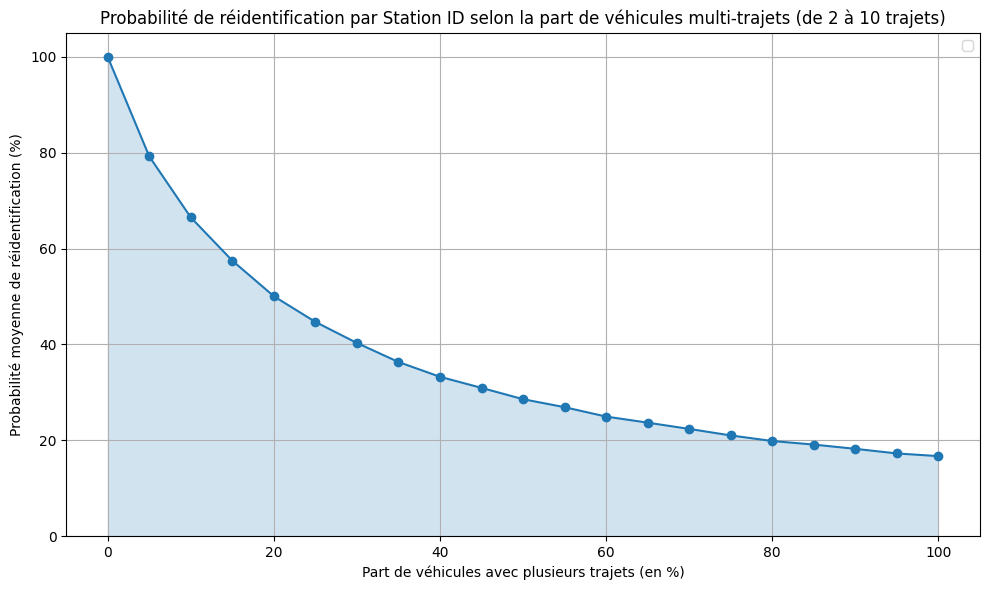

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Simulation avec multi-trajets de 2 à 10
def simulate_proba_curve_variable_multi():
    proportions = np.linspace(0, 1, 21)  # 0% à 100% de multi-trajets
    results = []

    total_vehicles = 10000

    for multi_ratio in proportions:
        single_vehicles = int((1 - multi_ratio) * total_vehicles)
        multi_vehicles = total_vehicles - single_vehicles

        trajet_distribution = {}
        trajet_distribution[1] = single_vehicles

        # Répartition aléatoire de 2 à 10 trajets pour les multi-vehicules
        multi_trajet_counts = np.random.choice(range(2, 11), size=multi_vehicles, replace=True)
        for n in multi_trajet_counts:
            trajet_distribution[n] = trajet_distribution.get(n, 0) + 1

        # Calcul de la proba
        total_trajets = sum(k * v for k, v in trajet_distribution.items())
        total_chances = sum((1 / k) * (k * v) for k, v in trajet_distribution.items())
        proba = total_chances / total_trajets

        results.append(proba)

    return proportions, results

# Lancer la simulation
x, y = simulate_proba_curve_variable_multi()

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(x * 100, [p * 100 for p in y], marker='o')
plt.fill_between(x * 100, [p * 100 for p in y], alpha=0.2)
plt.title("Probabilité de réidentification par Station ID selon la part de véhicules multi-trajets (de 2 à 10 trajets)")
plt.xlabel("Part de véhicules avec plusieurs trajets (en %)")
plt.ylabel("Probabilité moyenne de réidentification (%)")
plt.legend()
plt.grid(True)
plt.ylim(0, 105)
plt.tight_layout()
plt.show()

In [33]:
# Filtre sur le modèle
model_filter = df_trips["model_id"] == 2  # VW ID.4 / ID.5

# Heure de départ entre 14h45 (14.75) et 15h30 (15.5)
time_filter = df_trips["start_time"].dt.hour + df_trips["start_time"].dt.minute / 60
time_window = (time_filter >= 14.75) & (time_filter <= 15.25) #on a resséré ici sur 15h15

# Position approximative (zone Aix-la-Chapelle)
location_filter = (
    (df_trips["latitude_start"] >= 50.6) & (df_trips["latitude_start"] <= 50.9) &
    (df_trips["longitude_start"] >= 5.9) & (df_trips["longitude_start"] <= 6.3)
)

# Application du filtre global
filtered_candidates = df_trips[model_filter & time_window & location_filter]

# Résultat
print(f"Nombre de trajets correspondant aux critères : {len(filtered_candidates)}")

Nombre de trajets correspondant aux critères : 3


In [34]:
# Détails des trajets
print(filtered_candidates[[
    "trip_id", "station_id", "start_time", "latitude_start", "longitude_start",
    "model","speed_mean", "trip_duration_minutes"
]])

           trip_id  station_id                    start_time  latitude_start  \
1139  2783801127_1  2783801127 2024-01-26 15:00:47.173672061       50.780829   
1194  2886774960_1  2886774960 2024-02-05 15:05:19.121321126       50.771344   
1474  3328280022_1  3328280022 2024-01-13 14:57:23.316949719       50.782722   

      longitude_start              model  speed_mean  trip_duration_minutes  
1139         6.079164  VW ID.4 / VW ID.5    4.779924               1.599889  
1194         6.090283  VW ID.4 / VW ID.5    5.241319               4.141595  
1474         6.076615  VW ID.4 / VW ID.5    4.878652               1.033337  


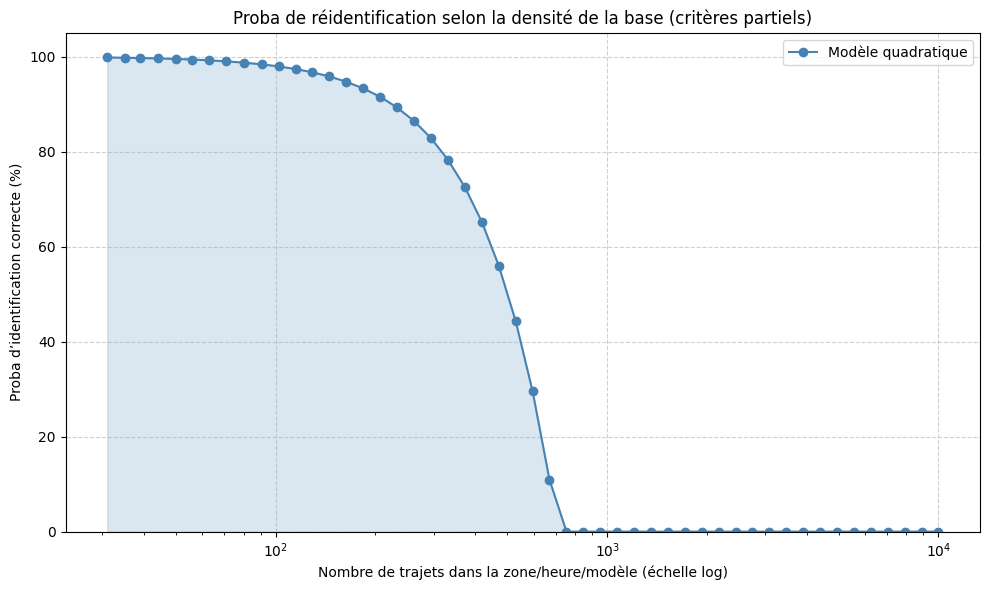

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction de simulation
def simulated_ambiguity(n_trajets, model_precision=0.9, time_precision=0.8, location_precision=0.7):
    ambiguity_factor = (n_trajets ** 2) / 1e6
    precision_boost = model_precision * time_precision * location_precision
    proba_confusion = min(ambiguity_factor / precision_boost, 1)
    return 1 - proba_confusion

# Échelle logarithmique pour meilleure lecture
trajet_sizes = np.logspace(1.5, 4, 50, dtype=int)  # de ~30 à 10000 trajets
proba_id = [simulated_ambiguity(n) for n in trajet_sizes]

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(trajet_sizes, np.array(proba_id) * 100, marker='o', color='steelblue', label="Modèle quadratique")

plt.fill_between(trajet_sizes, np.array(proba_id) * 100, alpha=0.2, color='steelblue')

plt.title("Proba de réidentification selon la densité de la base (critères partiels)")
plt.xlabel("Nombre de trajets dans la zone/heure/modèle (échelle log)")
plt.ylabel("Proba d’identification correcte (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0, 105)
plt.xscale("log")
plt.legend()
plt.tight_layout()
plt.show()

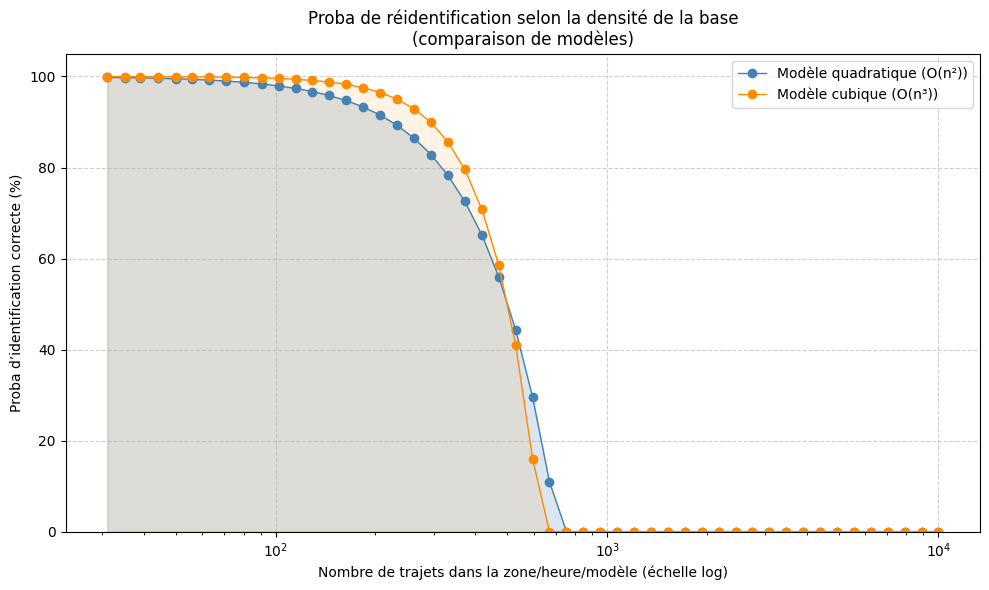

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction de simulation – quadratique
def simulated_ambiguity_quad(n, model_precision=0.9, time_precision=0.8, location_precision=0.7):
    ambiguity_factor = (n ** 2) / 1e6
    precision_boost = model_precision * time_precision * location_precision
    return max(0, 1 - min(ambiguity_factor / precision_boost, 1))

# Fonction de simulation – cubique
def simulated_ambiguity_cubic(n, model_precision=0.9, time_precision=0.8, location_precision=0.7):
    ambiguity_factor = (n ** 3) / 5e8
    precision_boost = model_precision * time_precision * location_precision
    return max(0, 1 - min(ambiguity_factor / precision_boost, 1))

# Gamme de tailles (échelle logarithmique pour clarté)
trajet_sizes = np.logspace(1.5, 4, 50, dtype=int)

# Calcul des probabilités
proba_quad = [simulated_ambiguity_quad(n) * 100 for n in trajet_sizes]
proba_cubic = [simulated_ambiguity_cubic(n) * 100 for n in trajet_sizes]

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(trajet_sizes, proba_quad, label="Modèle quadratique (O(n²))", marker ="o", color="steelblue", linewidth=1)
plt.plot(trajet_sizes, proba_cubic, label="Modèle cubique (O(n³))", marker ="o", color="darkorange", linewidth=1)

# Remplissage sous les courbes
plt.fill_between(trajet_sizes, proba_quad, alpha=0.2, color="steelblue")
plt.fill_between(trajet_sizes, proba_cubic, alpha=0.1, color="darkorange")

# Mise en forme
plt.xscale("log")
plt.title("Proba de réidentification selon la densité de la base\n(comparaison de modèles)")
plt.xlabel("Nombre de trajets dans la zone/heure/modèle (échelle log)")
plt.ylabel("Proba d’identification correcte (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0, 105)
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
import folium

# 1. Identifier les trajets ≥ 5 minutes
ids_long_trips = df_trips[df_trips["trip_duration_minutes"] >= 5][["trip_id", "station_id", "trip_duration_minutes"]]

# 2. Merge avec les points GPS dans `data`
data_long = data.merge(
    ids_long_trips,
    left_on="trip_id",
    right_on="trip_id",
    how="inner"
)

# 3. Carte centrée sur la moyenne des coordonnées GPS
center_lat = data_long["message_cam_cam_parameters_basic_container_reference_position_latitude_value"].mean() / 1e7
center_lon = data_long["message_cam_cam_parameters_basic_container_reference_position_longitude_value"].mean() / 1e7
m = folium.Map(location=[center_lat, center_lon], zoom_start=9)

# 4. Tracer les vraies trajectoires par trip_id
for trip_id, group in data_long.groupby("trip_id"):
    latitudes = group["message_cam_cam_parameters_basic_container_reference_position_latitude_value"] / 1e7
    longitudes = group["message_cam_cam_parameters_basic_container_reference_position_longitude_value"] / 1e7
    coordinates = list(zip(latitudes, longitudes))

    duration = group["trip_duration_minutes"].iloc[0]

    folium.PolyLine(
        locations=coordinates,
        color="blue",
        weight=3,
        opacity=0.7,
        tooltip=f"Trip ID: {trip_id} - Durée: {duration:.1f} min"
    ).add_to(m)

# 5. Afficher la carte
m

NameError: name 'data' is not defined

In [38]:
# Filtre sur la durée (entre 8 et 12 minutes)
duration_filter = (
    (df_trips["trip_duration_minutes"] >= 8) &
    (df_trips["trip_duration_minutes"] <= 12)
)

# Zone de départ ≈ Heckhauserhof
departure_filter = (
    df_trips["latitude_start"].between(51.13, 51.15) &
    df_trips["longitude_start"].between(6.59, 6.61)
)

# Zone d'arrivée ≈ Büttgen
arrival_filter = (
    df_trips["latitude_end"].between(51.18, 51.21) &
    df_trips["longitude_end"].between(6.60, 6.63)
)

# Application globale
filtered_candidates = df_trips[departure_filter & arrival_filter & duration_filter]

# Résultat
print(f"Nombre de trajets correspondant aux critères : {len(filtered_candidates)}")


Nombre de trajets correspondant aux critères : 1


In [39]:
import folium

# 1. Récupérer les trip_id sélectionnés
ids_selected = filtered_candidates[["trip_id", "station_id", "trip_duration_minutes"]]

# 2. Merge avec les points GPS issus de `data`
data_selected = data.merge(
    ids_selected,
    on="trip_id",
    how="inner"
)

# 3. Centrer la carte sur les coordonnées moyennes
center_lat = data_selected["message_cam_cam_parameters_basic_container_reference_position_latitude_value"].mean() / 1e7
center_lon = data_selected["message_cam_cam_parameters_basic_container_reference_position_longitude_value"].mean() / 1e7
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# 4. Tracer chaque trajectoire réelle (point par point)
for trip_id, group in data_selected.groupby("trip_id"):
    latitudes = group["message_cam_cam_parameters_basic_container_reference_position_latitude_value"] / 1e7
    longitudes = group["message_cam_cam_parameters_basic_container_reference_position_longitude_value"] / 1e7
    coordinates = list(zip(latitudes, longitudes))

    duration = group["trip_duration_minutes"].iloc[0]

    folium.PolyLine(
        locations=coordinates,
        color="darkred",
        weight=4,
        opacity=0.85,
        tooltip=f"Trip ID: {trip_id} - Durée: {duration:.1f} min"
    ).add_to(m)

# 5. Afficher la carte
m

NameError: name 'data' is not defined

In [ ]:
#df_trips.to_excel("df_trips.xlsx")

In [40]:
print(filtered_candidates[["trip_id","trip_local_id","station_id","longitude_start","latitude_start","longitude_end","longitude_end","start_time","end_time","trip_duration_minutes","model"]])

           trip_id  trip_local_id  station_id  longitude_start  \
1955  4066522203_1              1  4066522203         6.608407   

      latitude_start  longitude_end  longitude_end  \
1955       51.142024       6.612278       6.612278   

                        start_time                      end_time  \
1955 2024-01-30 12:22:39.084288831 2024-01-30 12:33:38.383194765   

      trip_duration_minutes                          model  
1955              10.988315  VW Golf 8 / ID.3 / Cupra Born  


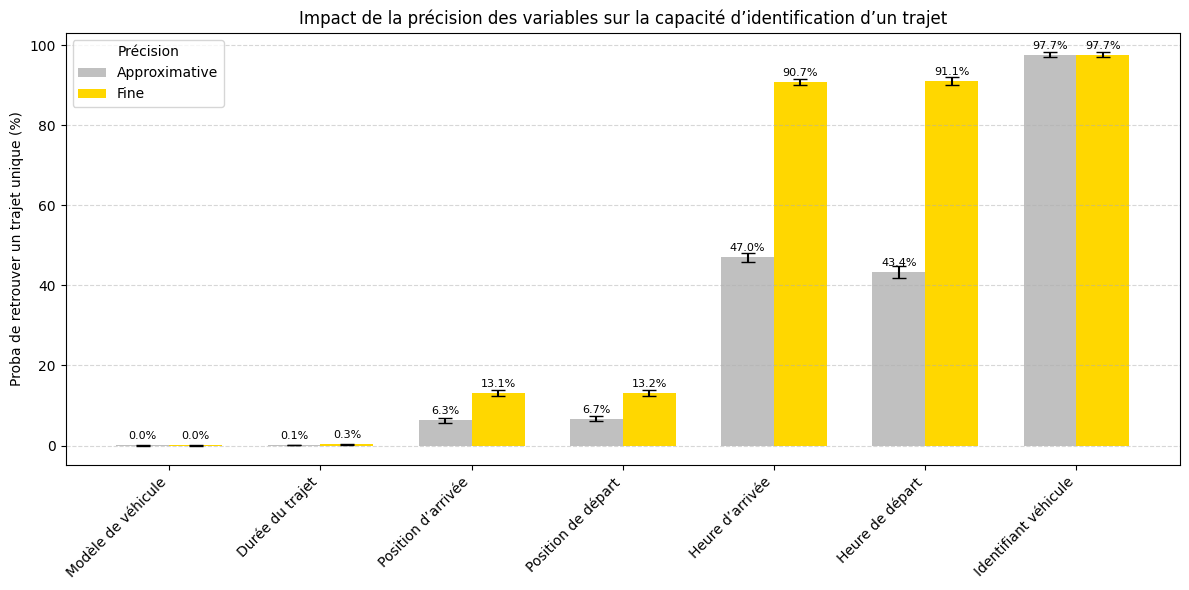

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Variables "Approximatives"
variables_grossier = {
    "Identifiant véhicule": df_trips["station_id"],
    "Modèle de véhicule": df_trips["model_id"],
    "Heure de départ": df_trips["start_time"].dt.strftime("%H:%M"),
    "Heure d’arrivée": df_trips["end_time"].dt.strftime("%H:%M"),
    "Position de départ": df_trips[["latitude_start", "longitude_start"]].round(2).astype(str).agg(",".join, axis=1),
    "Position d’arrivée": df_trips[["latitude_end", "longitude_end"]].round(2).astype(str).agg(",".join, axis=1),
    "Durée du trajet": (df_trips["trip_duration_minutes"] / 5).round() * 5  # par 5 min
}

# Variables "fines"
variables_fines = {
    "Identifiant véhicule": df_trips["station_id"],
    "Modèle de véhicule": df_trips["model_id"],
    "Heure de départ": df_trips["start_time"].dt.strftime("%Y-%m-%d %H:%M"),
    "Heure d’arrivée": df_trips["end_time"].dt.strftime("%Y-%m-%d %H:%M"),
    "Position de départ": df_trips[["latitude_start", "longitude_start"]].round(3).astype(str).agg(",".join, axis=1),
    "Position d’arrivée": df_trips[["latitude_end", "longitude_end"]].round(3).astype(str).agg(",".join, axis=1),
    "Durée du trajet": df_trips["trip_duration_minutes"].round()
}

# Fonction de calcul des unicités
def compute_unicity(series_dict, n_iter=30, frac=0.8):
    np.random.seed(42)
    results = {k: [] for k in series_dict}
    for _ in range(n_iter):
        sample = df_trips.sample(frac=frac)
        for label, series in series_dict.items():
            vals = series.loc[sample.index]
            ratio = vals.value_counts().eq(1).sum() / len(sample)
            results[label].append(ratio * 100)
    return pd.DataFrame({
        "Variable": list(results.keys()),
        "Moyenne": [np.mean(v) for v in results.values()],
        "Écart-type": [np.std(v) for v in results.values()]
    })

# Calculs
df_grossier = compute_unicity(variables_grossier)
df_grossier["Précision"] = "Approximative"

df_fine = compute_unicity(variables_fines)
df_fine["Précision"] = "Fine"

# Fusionner
df_all = pd.concat([df_grossier, df_fine], ignore_index=True)

# Tri des variables par la moyenne fine (ascendant)
fine_order = df_all[df_all["Précision"] == "Fine"].sort_values("Moyenne")["Variable"]
df_all["Variable"] = pd.Categorical(df_all["Variable"], categories=fine_order, ordered=True)
df_all = df_all.sort_values(by=["Variable", "Précision"])

# Palette de couleurs personnalisée
colors = {"Approximative": "#C0C0C0", "Fine": "#FFD700"}

# Préparer les données groupées
labels = df_all["Variable"].cat.categories
x = np.arange(len(labels))  # position des groupes
width = 0.35

fine_means = df_all[df_all["Précision"] == "Fine"]["Moyenne"].values
fine_stds = df_all[df_all["Précision"] == "Fine"]["Écart-type"].values
gross_means = df_all[df_all["Précision"] == "Approximative"]["Moyenne"].values
gross_stds = df_all[df_all["Précision"] == "Approximative"]["Écart-type"].values

# Création du graphe
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, gross_means, width, yerr=gross_stds, capsize=5,
               label='Approximative', color=colors["Approximative"])
bars2 = ax.bar(x + width/2, fine_means, width, yerr=fine_stds, capsize=5,
               label='Fine', color=colors["Fine"])

# Ajouter les valeurs % au-dessus de chaque barre
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, height + 1,
                    f"{height:.1f}%", ha='center', va='bottom', fontsize=8)

# Esthétique
ax.set_ylabel("Proba de retrouver un trajet unique (%)")
ax.set_title("Impact de la précision des variables sur la capacité d’identification d’un trajet")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend(title="Précision")
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [42]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

combinable_vars = {
    "Modèle": df_trips["model_id"],
    "Heure départ": df_trips["start_time"].dt.strftime("%Y-%m-%d %H:%M"),
    "Heure arrivée": df_trips["end_time"].dt.strftime("%Y-%m-%d %H:%M"),
    "Position départ": df_trips[["latitude_start", "longitude_start"]].round(3).astype(str).agg(",".join, axis=1),
    "Position arrivée": df_trips[["latitude_end", "longitude_end"]].round(3).astype(str).agg(",".join, axis=1),
    "Durée": df_trips["trip_duration_minutes"].round()
}

def compute_combo_unicity_split(vars_dict, n_iter=30, frac=0.8):
    results_2 = []
    results_3 = []
    keys = list(vars_dict.keys())

    for r in [2, 3]:
        for combo in itertools.combinations(keys, r):
            ratios = []
            for _ in range(n_iter):
                sample = df_trips.sample(frac=frac, random_state=None)
                combo_series = vars_dict[combo[0]].loc[sample.index].astype(str)
                for key in combo[1:]:
                    combo_series += "_" + vars_dict[key].loc[sample.index].astype(str)
                unique_count = combo_series.value_counts().eq(1).sum()
                ratio = unique_count / len(sample)
                ratios.append(ratio * 100)
            result = {
                "Combinaison": " + ".join(combo),
                "Moyenne": np.mean(ratios),
                "Écart-type": np.std(ratios)
            }
            if r == 2:
                results_2.append(result)
            else:
                results_3.append(result)
    
    return pd.DataFrame(results_2), pd.DataFrame(results_3)


In [43]:
# Lancer l'analyse
df_combo2, df_combo3 = compute_combo_unicity_split(combinable_vars)

# Trier pour affichage
df_combo2 = df_combo2.sort_values(by="Moyenne", ascending=False)
df_combo3 = df_combo3.sort_values(by="Moyenne", ascending=False)

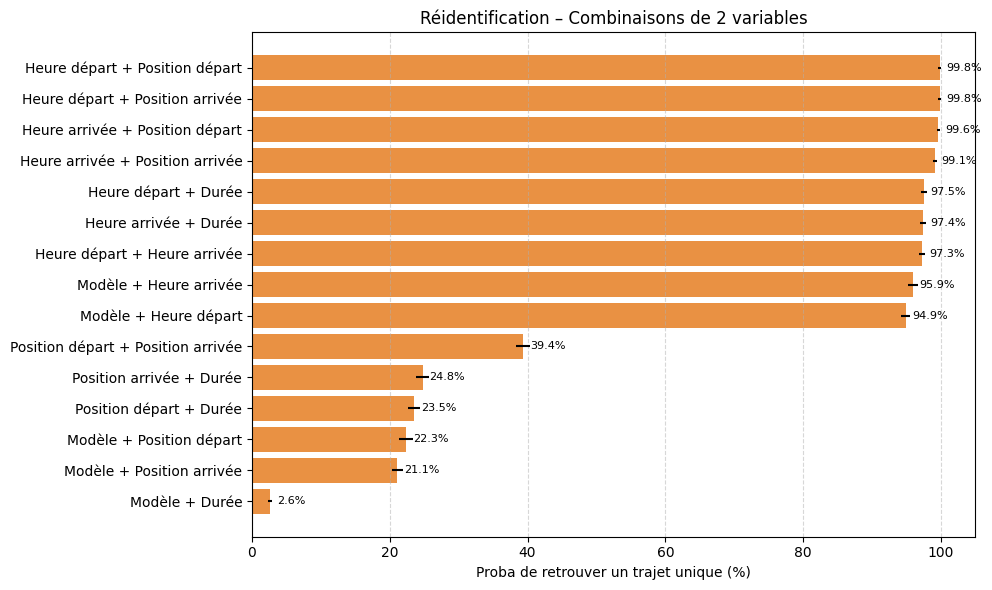

In [44]:
plt.figure(figsize=(10, 6))
plt.barh(df_combo2["Combinaison"], df_combo2["Moyenne"], xerr=df_combo2["Écart-type"], color="#e67e22", alpha=0.85)
plt.xlabel("Proba de retrouver un trajet unique (%)")
plt.title("Réidentification – Combinaisons de 2 variables")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle="--", alpha=0.5)

for i, v in enumerate(df_combo2["Moyenne"]):
    plt.text(v + 1, i, f"{v:.1f}%", va='center', fontsize=8)

plt.tight_layout()
plt.show()


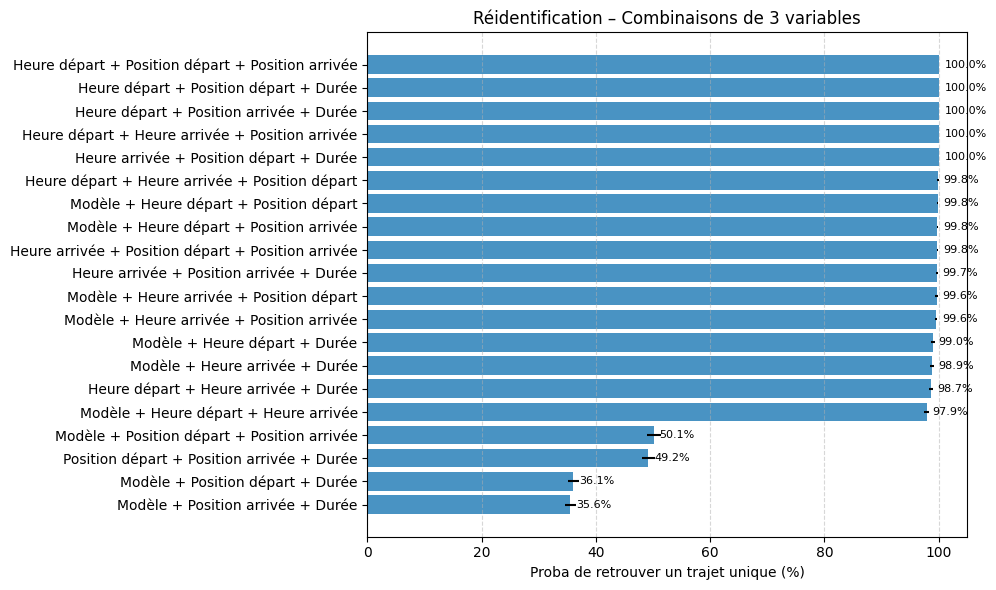

In [45]:
plt.figure(figsize=(10, 6))
plt.barh(df_combo3["Combinaison"], df_combo3["Moyenne"], xerr=df_combo3["Écart-type"], color="#2980b9", alpha=0.85)
plt.xlabel("Proba de retrouver un trajet unique (%)")
plt.title("Réidentification – Combinaisons de 3 variables")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle="--", alpha=0.5)

for i, v in enumerate(df_combo3["Moyenne"]):
    plt.text(v + 1, i, f"{v:.1f}%", va='center', fontsize=8)

plt.tight_layout()
plt.show()


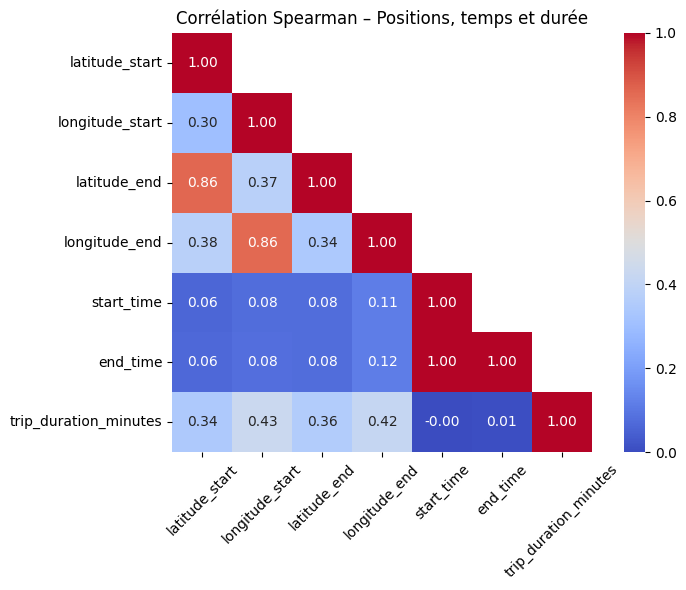

In [46]:
# Variables numériques finales
df_corr = df_trips[[
    "latitude_start", "longitude_start",
    "latitude_end", "longitude_end",
    "start_time", "end_time",
    "trip_duration_minutes"
]].copy()

# Ajout des minutes
df_corr["start_time"] = df_corr["start_time"].dt.hour * 60 + df_corr["start_time"].dt.minute
df_corr["end_time"] = df_corr["end_time"].dt.hour * 60 + df_corr["end_time"].dt.minute

# Sélection finale
df_corr_clean = df_corr[[
    "latitude_start", "longitude_start",
    "latitude_end", "longitude_end",
    "start_time", "end_time", "trip_duration_minutes"
]].dropna()

# Matrice de corrélation (Spearman)
corr_matrix = df_corr_clean.corr(method="spearman")

# Masque pour n'afficher que la partie inférieure
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Affichage
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", square=True,
            xticklabels=True, yticklabels=True, cbar=True)

plt.xticks(rotation=45)
plt.title("Corrélation Spearman – Positions, temps et durée")
plt.tight_layout()
plt.show()

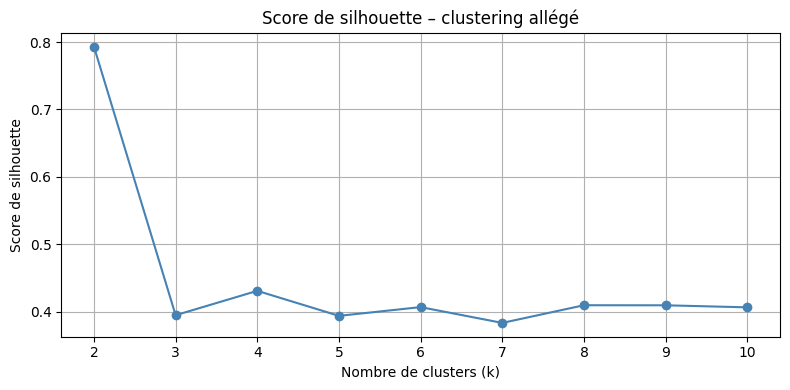

✅ Nombre de clusters optimal : 2


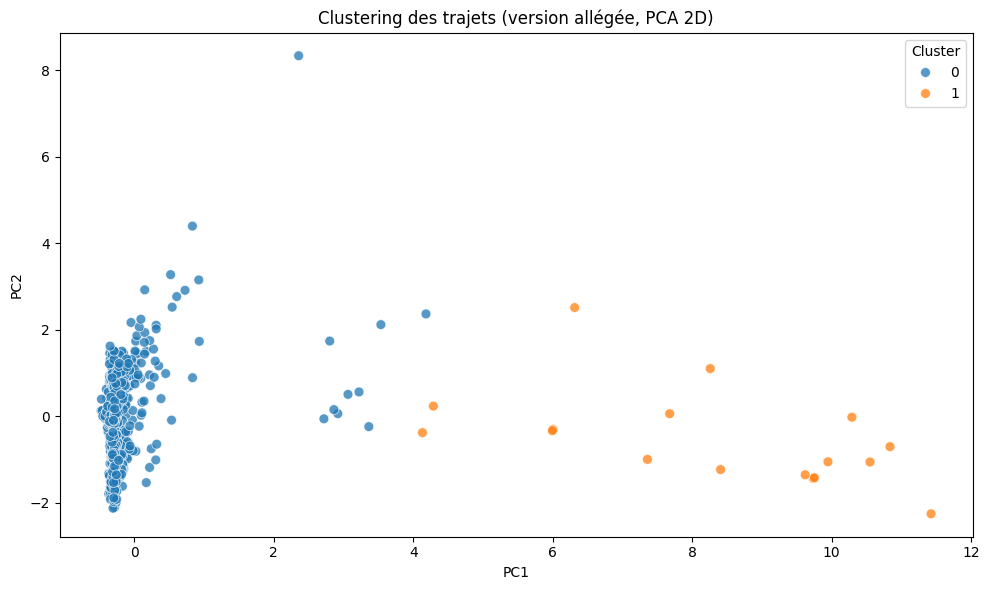

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Préparer les données
df_cluster_light = df_trips.copy()
df_cluster_light["start_min"] = df_cluster_light["start_time"].dt.hour * 60 + df_cluster_light["start_time"].dt.minute

features_light = [
    "trip_duration_minutes",
    "start_min",
    "latitude_start",
    "longitude_start"
]

X_light = df_cluster_light[features_light].dropna()

# 2. Normalisation
scaler = StandardScaler()
X_scaled_light = scaler.fit_transform(X_light)

# 3. Évaluation du meilleur k avec silhouette
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled_light)
    score = silhouette_score(X_scaled_light, labels)
    silhouette_scores.append(score)

# 4. Affichage
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker='o', color="steelblue")
plt.title("Score de silhouette – clustering allégé")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score de silhouette")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Clustering final
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"✅ Nombre de clusters optimal : {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_cluster_light["cluster_light"] = kmeans.fit_predict(X_scaled_light)

# 6. PCA pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_light)

# 7. Scatter plot
import seaborn as sns
df_plot_light = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_plot_light["cluster"] = df_cluster_light["cluster_light"].values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot_light, x="PC1", y="PC2", hue="cluster", palette="tab10", s=50, alpha=0.75)
plt.title("Clustering des trajets (version allégée, PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [48]:
from sklearn.decomposition import PCA
import pandas as pd

# 1. Fit PCA (déjà calculé juste avant si tu as fait X_scaled_light)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_light)

# 2. Variance expliquée
explained_var = pca.explained_variance_ratio_
print("✅ Variance expliquée par chaque composante :")
for i, var in enumerate(explained_var):
    print(f" - PC{i+1} : {var:.2%}")

# 3. Loadings (poids des variables dans chaque composante)
loadings = pd.DataFrame(
    pca.components_.T,
    index=features_light,
    columns=["PC1", "PC2"]
)

print("\n✅ Contribution (loadings) des variables aux composantes :")
print(loadings.round(3))

✅ Variance expliquée par chaque composante :
 - PC1 : 45.73%
 - PC2 : 25.50%

✅ Contribution (loadings) des variables aux composantes :
                         PC1    PC2
trip_duration_minutes  0.195  0.569
start_min             -0.004  0.806
latitude_start        -0.683  0.162
longitude_start        0.703  0.004


In [49]:
# 1. S'assurer que les colonnes nécessaires sont présentes
df_summary = df_cluster_light.copy()

# 2. Regrouper par cluster et calculer les moyennes
cluster_summary = df_summary.groupby("cluster_light")[[
    "trip_duration_minutes",
    "start_min",
    "latitude_start",
    "longitude_start"
]].agg(["mean", "std", "min", "max", "count"])

# 3. Affichage
import pandas as pd
pd.set_option("display.precision", 2)
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary = cluster_summary.reset_index()

# 4. Afficher le tableau
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

import matplotlib.pyplot as plt
from tabulate import tabulate

print(tabulate(cluster_summary, headers="keys", tablefmt="github"))

|    |   cluster_light |   trip_duration_minutes_mean |   trip_duration_minutes_std |   trip_duration_minutes_min |   trip_duration_minutes_max |   trip_duration_minutes_count |   start_min_mean |   start_min_std |   start_min_min |   start_min_max |   start_min_count |   latitude_start_mean |   latitude_start_std |   latitude_start_min |   latitude_start_max |   latitude_start_count |   longitude_start_mean |   longitude_start_std |   longitude_start_min |   longitude_start_max |   longitude_start_count |
|----|-----------------|------------------------------|-----------------------------|-----------------------------|-----------------------------|-------------------------------|------------------|-----------------|-----------------|-----------------|-------------------|-----------------------|----------------------|----------------------|----------------------|------------------------|------------------------|-----------------------|-----------------------|-----------------------|---

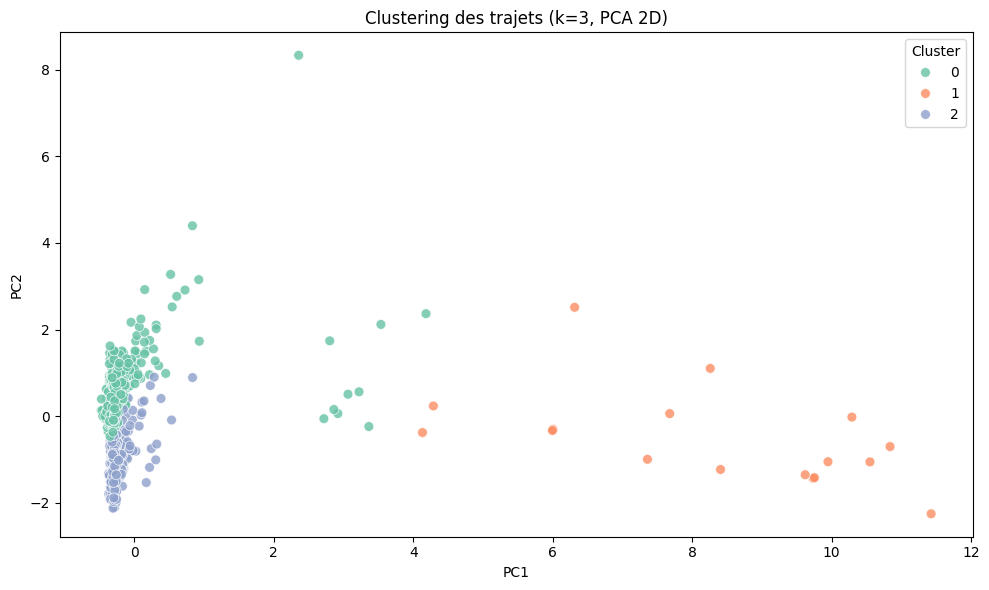

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Reprise des données et transformation
df_cluster_k3 = df_trips.copy()
df_cluster_k3["start_min"] = df_cluster_k3["start_time"].dt.hour * 60 + df_cluster_k3["start_time"].dt.minute

features_light = [
    "trip_duration_minutes",
    "start_min",
    "latitude_start",
    "longitude_start"
]

X_k3 = df_cluster_k3[features_light].dropna()
scaler = StandardScaler()
X_scaled_k3 = scaler.fit_transform(X_k3)

# 2. Clustering KMeans avec k=3
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
df_cluster_k3["cluster_k3"] = kmeans_k3.fit_predict(X_scaled_k3)

# 3. PCA pour visualisation
pca_k3 = PCA(n_components=2)
X_pca_k3 = pca_k3.fit_transform(X_scaled_k3)

# 4. Scatter plot PCA
df_plot_k3 = pd.DataFrame(X_pca_k3, columns=["PC1", "PC2"])
df_plot_k3["cluster"] = df_cluster_k3["cluster_k3"].values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot_k3, x="PC1", y="PC2", hue="cluster", palette="Set2", s=50, alpha=0.8)
plt.title("Clustering des trajets (k=3, PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [51]:
# 1. Copier les données utiles
df_summary_k3 = df_cluster_k3.copy()

# 2. Grouper par cluster_k3 et calculer statistiques
cluster_summary_k3 = df_summary_k3.groupby("cluster_k3")[[
    "trip_duration_minutes",
    "start_min",
    "latitude_start",
    "longitude_start"
]].agg(["mean", "std", "min", "max", "count"])

# 3. Mise en forme du tableau
cluster_summary_k3.columns = ['_'.join(col).strip() for col in cluster_summary_k3.columns.values]
cluster_summary_k3 = cluster_summary_k3.reset_index()

# 4. Affichage dans le terminal
from tabulate import tabulate
print(tabulate(cluster_summary_k3, headers="keys", tablefmt="github"))


|    |   cluster_k3 |   trip_duration_minutes_mean |   trip_duration_minutes_std |   trip_duration_minutes_min |   trip_duration_minutes_max |   trip_duration_minutes_count |   start_min_mean |   start_min_std |   start_min_min |   start_min_max |   start_min_count |   latitude_start_mean |   latitude_start_std |   latitude_start_min |   latitude_start_max |   latitude_start_count |   longitude_start_mean |   longitude_start_std |   longitude_start_min |   longitude_start_max |   longitude_start_count |
|----|--------------|------------------------------|-----------------------------|-----------------------------|-----------------------------|-------------------------------|------------------|-----------------|-----------------|-----------------|-------------------|-----------------------|----------------------|----------------------|----------------------|------------------------|------------------------|-----------------------|-----------------------|-----------------------|---------

In [67]:
import folium
import pandas as pd
from folium import plugins

# 1. Charger le DataFrame avec clusters
df_map = df_cluster_k3.copy()

# 2. Centrer la carte sur la zone moyenne de départs
center_lat = df_map["latitude_start"].mean()
center_lon = df_map["longitude_start"].mean()

# 3. Créer la carte
m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles="CartoDB positron")

# 4. Palette manuelle de couleurs
colors = {
    0: "blue",
    1: "red",
    2: "green"
}

# 5. Ajout des points sur la carte
for _, row in df_map.iterrows():
    folium.CircleMarker(
        location=[row["latitude_start"], row["longitude_start"]],
        radius=3,
        color=colors[row["cluster_k3"]],
        fill=True,
        fill_opacity=0.4,
        tooltip=f"Cluster {row['cluster_k3']}"
    ).add_to(m)

# 6. Option : ajouter un layer control si besoin
folium.LayerControl().add_to(m)

# 7. Afficher la carte
m

In [70]:
import folium
import pandas as pd

# On arrondit les coordonnées pour grouper les points proches
df_map["lat_agg"] = df_map["latitude_start"].round(3)
df_map["lon_agg"] = df_map["longitude_start"].round(3)

# Groupe par coordonnées arrondies + cluster
grouped = df_map.groupby(["cluster_k3", "lat_agg", "lon_agg"]).size().reset_index(name="count")

# Couleurs manuelles
colors = {
    0: "blue",
    1: "red",
    2: "green"
}

# Carte centrée
center_lat = df_map["latitude_start"].mean()
center_lon = df_map["longitude_start"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=7, tiles="CartoDB positron")

# Ajouter des cercles proportionnels au nombre de trajets
for _, row in grouped.iterrows():
    folium.CircleMarker(
        location=[row["lat_agg"], row["lon_agg"]],
        radius=3 + row["count"]**0.5,  # rayon proportionnel à √(nb points)
        color=colors[row["cluster_k3"]],
        fill=True,
        fill_opacity=0.8,
        tooltip=f"Cluster {row['cluster_k3']}<br>{row['count']} trajets"
    ).add_to(m)

folium.LayerControl().add_to(m)
m

In [53]:
# Copie pour traitement
df_risk = df_cluster_k3.copy()

# Transformer start_time en format "précis" (date + heure + minute)
df_risk["start_label"] = df_risk["start_time"].dt.strftime("%Y-%m-%d %H:%M")

# Fonction pour calculer unicité sur une variable dans chaque cluster
def uniqueness_per_cluster(df, cluster_col, value_col):
    results = []

    for cluster_id, group in df.groupby(cluster_col):
        total = len(group)
        counts = group[value_col].value_counts()
        unique_count = (counts == 1).sum()
        ratio = unique_count / total * 100
        results.append({
            "cluster": cluster_id,
            "nb_trajets": total,
            "nb_uniques": unique_count,
            "taux_unicité (%)": round(ratio, 2)
        })

    return pd.DataFrame(results).sort_values(by="taux_unicité (%)", ascending=False)

# Calcul sur l'heure de départ
unicity_cluster_start = uniqueness_per_cluster(df_risk, "cluster_k3", "start_label")

# Affichage
from tabulate import tabulate
print(tabulate(unicity_cluster_start, headers="keys", tablefmt="github"))

|    |   cluster |   nb_trajets |   nb_uniques |   taux_unicité (%) |
|----|-----------|--------------|--------------|--------------------|
|  1 |         1 |           17 |           17 |             100    |
|  2 |         2 |          277 |          256 |              92.42 |
|  0 |         0 |          474 |          411 |              86.71 |


In [54]:
# Création label combiné : start time + position de départ
df_risk["start_pos_label"] = (
    df_risk["start_time"].dt.strftime("%Y-%m-%d %H:%M") + " / " +
    df_risk["latitude_start"].round(3).astype(str) + "," +
    df_risk["longitude_start"].round(3).astype(str)
)

# Calcul unicité
unicity_cluster_start_pos = uniqueness_per_cluster(df_risk, "cluster_k3", "start_pos_label")
print("\n🎯 Unicité : Start time + Position de départ")
print(tabulate(unicity_cluster_start_pos, headers="keys", tablefmt="github"))


🎯 Unicité : Start time + Position de départ
|    |   cluster |   nb_trajets |   nb_uniques |   taux_unicité (%) |
|----|-----------|--------------|--------------|--------------------|
|  1 |         1 |           17 |           17 |             100    |
|  2 |         2 |          277 |          277 |             100    |
|  0 |         0 |          474 |          472 |              99.58 |


In [55]:
# Création label combiné : start + pos départ + durée
df_risk["start_pos_duree_label"] = (
    df_risk["start_time"].dt.strftime("%Y-%m-%d %H:%M") + " / " +
    df_risk["latitude_start"].round(3).astype(str) + "," +
    df_risk["longitude_start"].round(3).astype(str) + " / " +
    df_risk["trip_duration_minutes"].round().astype(str) + " min"
)

# Calcul unicité
unicity_cluster_all = uniqueness_per_cluster(df_risk, "cluster_k3", "start_pos_duree_label")
print("\n🎯 Unicité : Start time + Position de départ + Durée")
print(tabulate(unicity_cluster_all, headers="keys", tablefmt="github"))


🎯 Unicité : Start time + Position de départ + Durée
|    |   cluster |   nb_trajets |   nb_uniques |   taux_unicité (%) |
|----|-----------|--------------|--------------|--------------------|
|  0 |         0 |          474 |          474 |                100 |
|  1 |         1 |           17 |           17 |                100 |
|  2 |         2 |          277 |          277 |                100 |
